# Calculate Z-scores for players

This takes the list of players that we're trying to calculate scores for, and creates z-scores for players with an arbitrarily chosen minimum innings (for pitchers) or plate appearances (for hitters).

Notes for this year's sheet:

- Z-score avg/stdev calculated using minimum IP (70) or PA (35) stats for batting and pitching.
- Reliever value was artificially decremented as usual since they're normally over-inflated value-wise. Multiplied by (project innings) / (90th pctile of projected innings), capped at 1.0.

In [46]:
import pandas as pd
import numpy as np
import os
import sqlalchemy
import psycopg2
import seaborn as sb

# arbitrarily high max view columns
pd.options.display.max_columns = 150
pd.options.display.max_rows = 200

## SqlAlchemy Connection Information

These are used to get and return a connection to the postgres DB so that we can query for player stats and write them back to the table.

In [2]:
# connection information for the database
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_IP = "192.168.0.118"
POSTGRES_PORT = 5432
POSTGRES_DB = "postgres"

def get_sqlalchemy_engine():
    """
    Create and return a SQLAlchemy engine for inserting into postgres.
    """
    # ## Write Information Back to Database
    #
    return sqlalchemy.create_engine(
        "postgres://{user}:{password}@{host}:{port}/{db}".format(
            user=POSTGRES_USER,
            password=POSTGRES_PASSWORD,
            host=POSTGRES_IP,
            port=POSTGRES_PORT,
            db=POSTGRES_DB,
        )
    )

In [34]:
# create a connection and read in pitchers data
engine = get_sqlalchemy_engine()
conn = engine.connect()

## Calculate Z-Scores

For each of the players, we calculate a z-score based on how they compare to the rest of the league. There are several columns that we want to do this for.

- For each z-score, there is an arbitrary minimum set to inflate the league average away from non-full-time players.
- After each is totaled, the z-scores are totaled and then z-scored again to make a single number. This is done so that we can compare pitchers and batters into the same chart.

In [61]:
# read in information from postgres
dfp = pd.read_sql("select * from fantasy.pitchers_projections_depth_charts", conn)
dfb = pd.read_sql("select * from fantasy.batters_projections_depth_charts", conn)

In [62]:
# create any calculated columns necessary
dfb['k_pct'] = dfb['so'] / dfb['ab']
dfb['rc'] = dfb['ab'] * dfb['obp'] * dfb['slg']

# quality starts metric from here:
# https://yourfantasyjoe.blogspot.com/2010/02/projecting-quality-starts.html
# xQS = GS * (.4650115 - (ERA * .0872381) + ((IP/GS) * .0746775))
dfp['qs'] = dfp['gs'] * (0.4650115 - (dfp['era'] * 0.0872381) + ((dfp['ip']/dfp['gs']) * .0746775))

In [63]:
# thresholds for batters and pitchers
MINIMUM_INNINGS_PITCHED = 100
MINIMUM_PLATE_APPEARANCES = 400
min_pa = dfb['pa'] > MINIMUM_PLATE_APPEARANCES
min_ip = dfp['ip'] > MINIMUM_INNINGS_PITCHED

# dict of columns that we want to calculate z-scores for
# +1 means more is better, -1 means negative is better
dfb_score_cols = {
    "pa": {"dir": 1, "weight": 1.3}, 
    "k_pct": {"dir": -1, "weight": 1.0},
    "hr": {"dir": 1, "weight": 0.9},
    "rc": {"dir": 1, "weight": 1.4},
    "woba": {"dir": 1, "weight": 1.3},
    "slg": {"dir": 1, "weight": 1.0},
    "adp": {"dir": -1, "weight": 0.5}
}
dfp_score_cols = {
    "ip": {"dir": 1, "weight": 1.3},
    "era": {"dir": -1, "weight": 1.0},
    "hr": {"dir": -1, "weight": 0.9},
    "so": {"dir": 1, "weight": 1.0},
    "whip": {"dir": -1, "weight": 1.5},
    "k-9": {"dir": 1, "weight": 1.3},
    "qs": {"dir": 1, "weight": 1.0},
    "gs": {"dir": 1, "weight": 1.2}
}
dfb_weight = 1.0
dfp_weight = 0.88

# get all of the score columns for maximum z-scoring
dfb_score_col_names = [x + "_score" for x in dfb_score_cols.keys()]
dfp_score_col_names = [x + "_score" for x in dfp_score_cols.keys()]

In [64]:
# only mean and stdev are filtered by minimums, so that way the player's actual
# projections are still counted normally.

for col in dfb_score_cols.keys():
    col_score = col + "_score"
    dfb[col_score] = (
        (dfb[col] - dfb[col][min_pa].mean()) / dfb[col][min_pa].std(ddof=0)
        * dfb_score_cols[col]["dir"]
        * dfb_score_cols[col]["weight"]
    )

for col in dfp_score_cols.keys():
    col_score = col + "_score"
    dfp[col_score] = (
        (dfp[col] - dfp[col][min_ip].mean()) / dfp[col][min_ip].std(ddof=0)
        * dfp_score_cols[col]["dir"]
        * dfp_score_cols[col]["weight"]
    )

In [83]:
# sum all of the values into 'total_score'
dfb['total_score'] = dfb[dfb_score_col_names].sum(axis=1)
dfb['total_z_score'] = (
    dfb['total_score'] - dfb['total_score'][min_pa].mean()) / dfb['total_score'][min_pa].std(ddof=0)
dfb['total_z_score_rank'] = dfb['total_z_score'].rank(ascending=False)

dfp['total_score'] = dfp[dfp_score_col_names].sum(axis=1)
dfp['total_z_score'] = (
    dfp['total_score'] - dfp['total_score'][min_ip].mean()) / dfp['total_score'][min_ip].std(ddof=0)
dfp['total_z_score_rank'] = dfp['total_z_score'].rank(ascending=False)

# sort by score descending
dfb.sort_values(by='total_z_score_rank', inplace=True)
dfp.sort_values(by='total_z_score_rank', inplace=True)


### Inflate League Mean

For the majority of the z-scores that we're taking, the actual values of them are affected by the long-tail of players who don't get much playing time. To offset this, the mean is artifically placed at halfway through our number of drafted players to account for the fact that will be replacement level for our league.

In [84]:
# decrement scores by the mean of all drafted positions
NUM_TEAMS = 8
NUM_BATTERS = 15
NUM_PITCHERS = 10

MIDDLE_BATTER_INDEX = (NUM_TEAMS * NUM_BATTERS) / 2
MIDDLE_PITCHER_INDEX = (NUM_TEAMS * NUM_PITCHERS) / 2

In [85]:
middle_batter_score = dfb[dfb['total_z_score_rank'] == MIDDLE_BATTER_INDEX]['total_z_score']
dfb['total_z_score'] = dfb['total_z_score'] - float(middle_batter_score)
dfb['total_z_score'] *= dfb_weight

middle_pitcher_score = dfp[dfp['total_z_score_rank'] == MIDDLE_PITCHER_INDEX]['total_z_score']
dfp['total_z_score'] = dfp['total_z_score'] - float(middle_pitcher_score)


# apply weights by how far above zero the player is (capped at zero for negatives)
max_score = float(dfp['total_z_score'].max())
dfp['weight_diff'] = dfp['total_z_score'].apply(lambda x: max(0.0, x / max_score))
dfp['weight_scale'] = dfp['weight_diff'].apply(lambda x: dfp_weight + ((1 - x) * (1 - dfp_weight)))
dfp['total_z_score'] = dfp['total_z_score'] * dfp['weight_scale']

## Top Batter Results

In [68]:
dfb.head(50)

,index,name,g,pa,ab,h,2b,3b,hr,r,rbi,bb,so,hbp,sb,cs,avg,obp,slg,ops,woba,fld,bsr,war,adp,k_pct,rc,pa_score,k_pct_score,hr_score,rc_score,woba_score,slg_score,adp_score,total_score,total_z_score,total_z_score_rank
0,0,Mike Trout,157,658,517,153,28,4,40,114,101,124,135,10,23,6,0.295,0.437,0.595,1.032,0.427,0.4,3.6,9.2,1.1,0.261122,134.427755,1.519772,-0.287730,2.297863,4.713972,4.859839,3.262436,0.666996,17.033149,2.252111,1.0
4,4,Mookie Betts,162,679,591,178,43,4,29,115,95,76,92,5,27,7,0.301,0.382,0.532,0.913,0.386,16.9,5.3,7.4,1.9,0.155668,120.105384,1.890399,1.382255,1.073991,3.602870,2.837132,1.986617,0.664923,13.438186,1.623633,2.0
3,3,J.D. Martinez,155,651,576,169,35,2,39,98,117,66,163,4,4,2,0.293,0.366,0.565,0.931,0.389,-0.1,-1.8,4.0,6.1,0.282986,119.111040,1.396230,-0.633977,2.186602,3.525731,2.985135,2.654903,0.654043,12.768666,1.506586,3.0
10,10,Nolan Arenado,155,651,578,166,38,4,36,97,112,62,114,3,3,2,0.287,0.357,0.550,0.907,0.379,7.0,-0.5,4.9,7.1,0.197232,113.490300,1.396230,0.724046,1.852819,3.089684,2.491791,2.351136,0.651452,12.557159,1.469610,4.0
1,1,Juan Soto,152,637,539,158,30,3,32,98,101,92,122,2,7,3,0.294,0.397,0.538,0.935,0.395,-4.7,0.4,4.7,35.3,0.226345,115.122854,1.149146,0.263002,1.407775,3.216335,3.281141,2.108123,0.578395,12.003916,1.372891,5.0
8,8,Jose Ramirez,155,651,562,162,41,4,28,100,94,77,74,5,25,8,0.289,0.377,0.522,0.899,0.380,3.8,3.7,6.3,4.2,0.131673,110.598228,1.396230,1.762257,0.962730,2.865323,2.541126,1.784105,0.658965,11.970736,1.367090,6.0
12,12,Anthony Rizzo,155,651,548,153,33,2,28,88,98,78,89,19,8,4,0.279,0.384,0.501,0.885,0.375,4.9,-1.4,4.3,37.7,0.162409,105.426432,1.396230,1.275512,0.962730,2.464105,2.294454,1.358832,0.572177,10.324041,1.079212,7.0
5,5,Christian Yelich,155,651,567,169,35,4,27,98,94,72,136,6,17,5,0.297,0.380,0.519,0.898,0.383,2.3,2.7,5.2,6.8,0.239859,111.823740,1.396230,0.048994,0.851469,2.960396,2.689129,1.723352,0.652229,10.321800,1.078820,8.0
2,2,Bryce Harper,148,623,500,133,27,1,35,97,100,112,147,4,12,5,0.266,0.401,0.533,0.934,0.392,-3.5,0.8,4.8,16.9,0.294000,106.866500,0.902062,-0.808396,1.741558,2.575823,3.133138,2.006868,0.626063,10.177115,1.053526,9.0
9,9,Freddie Freeman,157,658,565,165,39,3,27,91,93,80,132,8,8,3,0.292,0.384,0.513,0.897,0.379,5.2,0.4,4.6,21.6,0.233628,111.300480,1.519772,0.147663,0.851469,2.919802,2.491791,1.601846,0.613887,10.146231,1.048127,10.0


## Top Pitcher Results

In [86]:
## Top Pitchers
dfp.head(50)

,index,name,w,l,sv,hld,era,gs,g,ip,h,er,hr,so,bb,whip,k-9,bb-9,fip,war,qs,ip_score,era_score,hr_score,so_score,whip_score,k-9_score,qs_score,gs_score,total_score,total_z_score,total_z_score_rank,weight_diff,weight_scale
14,14,Max Scherzer,16,8,0,0,3.06,32,32,210.0,162,71,25,271,54,1.03,11.61,2.32,3.04,5.7,22.020288,2.736270,2.149518,-0.925241,3.348126,4.039903,3.521524,2.474422,1.599055,18.943577,1.910251,1.0,1.000000,0.880000
5,5,Jacob deGrom,14,9,0,0,2.84,32,32,211.0,174,67,20,249,50,1.06,10.59,2.14,2.82,6.0,22.709122,2.785325,2.556460,0.157334,2.780559,3.617711,2.478382,2.690218,1.599055,18.665045,1.879412,2.0,0.981362,0.882237
1,1,Chris Sale,15,6,0,0,2.70,29,29,183.0,141,55,18,238,38,0.97,11.67,1.85,2.63,6.0,20.320573,1.411794,2.815424,0.590364,2.496776,4.884286,3.582885,1.941941,0.787809,18.511278,1.862309,3.0,0.971072,0.883471
27,27,Justin Verlander,16,8,0,0,3.20,32,32,204.0,164,72,26,243,49,1.04,10.73,2.18,3.27,5.2,21.181397,2.441942,1.890555,-1.141756,2.625768,3.899172,2.621558,2.211617,1.599055,16.147912,1.592507,4.0,0.812926,0.902449
22,22,Corey Kluber,16,9,0,0,3.27,32,32,211.0,187,77,23,220,43,1.09,9.37,1.82,3.22,5.3,21.508726,2.785325,1.761073,-0.492211,2.032404,3.195520,1.230703,2.314162,1.599055,14.426030,1.387732,5.0,0.697705,0.916275
25,25,Gerrit Cole,14,8,0,0,3.35,32,32,198.0,167,73,22,231,57,1.14,10.51,2.61,3.25,4.8,20.314589,2.147614,1.613094,-0.275696,2.316187,2.491868,2.396567,1.940066,1.599055,14.228755,1.363829,6.0,0.684504,0.917860
34,34,Blake Snell,15,10,0,0,3.15,32,32,190.0,153,66,18,224,75,1.20,10.63,3.55,3.30,4.0,20.275493,1.755177,1.983042,0.590364,2.135597,1.647485,2.519289,1.927818,1.599055,14.157827,1.355213,7.0,0.679758,0.918429
40,40,Carlos Carrasco,15,9,0,0,3.41,32,32,194.0,175,73,23,212,45,1.13,9.83,2.08,3.33,4.5,19.848382,1.951395,1.502110,-0.492211,1.826016,2.632598,1.701139,1.794014,1.599055,12.514117,1.152254,8.0,0.569768,0.931628
55,55,Trevor Bauer,14,9,0,0,3.47,32,32,191.0,166,74,20,215,67,1.22,10.09,3.15,3.42,4.3,19.456852,1.804231,1.391126,0.157334,1.903411,1.366024,1.967038,1.671357,1.599055,11.859576,1.069679,9.0,0.525969,0.936884
46,46,Aaron Nola,13,9,0,0,3.39,31,31,189.0,170,71,20,200,51,1.17,9.49,2.44,3.36,4.2,19.361552,1.706122,1.539105,0.157334,1.516434,2.069676,1.353425,1.641502,1.328640,11.312238,0.999861,10.0,0.489343,0.941279


## Write to the Database

Prior to writing the excel files, write back to the database for safekeeping.

In [87]:
dfb.to_sql("batters_scores", conn, schema="fantasy", if_exists="replace")
result = conn.execute("grant select on fantasy.batters_scores to public")
dfp.to_sql("pitchers_scores", conn, schema="fantasy", if_exists="replace")
result = conn.execute("grant select on fantasy.pitchers_scores to public")

## Create Draft Sheet

This sheet includes a number of important pieces of information for drafting specifically, so that players can look up by eligibility as well as important stats.

- Name
- Eligibility
- Positions
- Combined scores

In [102]:
draft_sheet_query = """
select
    p.fullname,
    p.eligibility,
    p.position,
    p.injurystatus,
    upper(sc.catg) as category,
    p.averagedraftposition as espn_adp,
    p.auctionvalue as espn_auctionvalue,
    sc.score
from fantasy.players p
    left join (
        select name, 'b' as catg, total_z_score as score
        from fantasy.batters_scores
        union all
        select name, 'p' as catg, total_z_score as score
        from fantasy.pitchers_scores
    ) sc
        on p.fullname = sc.name
        and case when position like '%P%' then 'p' else 'b' end = sc.catg
"""
dfd = pd.read_sql(sqlalchemy.text(draft_sheet_query), conn)

In [103]:
dfd.sort_values(by='score', inplace=True, ascending=False)
dfd.head(100)
dfd['rank'] = dfd['score'].rank(ascending=False, method='first', na_option='bottom')
dfd.reset_index(drop=True)

,fullname,eligibility,position,injurystatus,category,espn_adp,espn_auctionvalue,score,rank
0,Mike Trout,OF|UTIL,OF,ACTIVE,B,1.49,38.0,2.252111,1.0
1,Max Scherzer,P|SP,SP,ACTIVE,P,5.24,33.0,1.910251,2.0
2,Jacob deGrom,P|SP,SP,ACTIVE,P,12.04,27.0,1.879412,3.0
3,Chris Sale,P|SP,SP,ACTIVE,P,9.22,29.0,1.862309,4.0
4,Mookie Betts,OF|UTIL,OF,ACTIVE,B,2.52,37.0,1.623633,5.0
5,Justin Verlander,P|SP,SP,ACTIVE,P,18.89,24.0,1.592507,6.0
6,J.D. Martinez,OF|UTIL,OF|DH,ACTIVE,B,5.87,34.0,1.506586,7.0
7,Nolan Arenado,3B|1B/3B|UTIL,3B,ACTIVE,B,6.09,31.0,1.469610,8.0
8,Corey Kluber,P|SP,SP,ACTIVE,P,19.44,25.0,1.387732,9.0
9,Juan Soto,OF|UTIL,OF,ACTIVE,B,34.37,21.0,1.372891,10.0


## Draft Sheet Preview

This is a quick look at how the players are going to appear in the final draft sheet. Useful for comparing overall pitcher v batter weights (i.e. verify that nobody should be ranked higher than trout).

In [91]:
dfd.head(200)

,fullname,eligibility,position,injurystatus,category,espn_adp,espn_auctionvalue,score,rank
0,Mike Trout,OF|UTIL,OF,ACTIVE,B,1.49,38.0,2.252111,1.0
543,Max Scherzer,P|SP,SP,ACTIVE,P,5.24,33.0,1.910251,2.0
544,Jacob deGrom,P|SP,SP,ACTIVE,P,12.04,27.0,1.879412,3.0
545,Chris Sale,P|SP,SP,ACTIVE,P,9.22,29.0,1.862309,4.0
1,Mookie Betts,OF|UTIL,OF,ACTIVE,B,2.52,37.0,1.623633,5.0
546,Justin Verlander,P|SP,SP,ACTIVE,P,18.89,24.0,1.592507,6.0
2,J.D. Martinez,OF|UTIL,OF|DH,ACTIVE,B,5.87,34.0,1.506586,7.0
3,Nolan Arenado,3B|1B/3B|UTIL,3B,ACTIVE,B,6.09,31.0,1.469610,8.0
547,Corey Kluber,P|SP,SP,ACTIVE,P,19.44,25.0,1.387732,9.0
4,Juan Soto,OF|UTIL,OF,ACTIVE,B,34.37,21.0,1.372891,10.0


## Style Output

In order to make the outputs more usable, apply a number of color stylings and ranking scale sliders to the actual xlsx file.

## Write Excel files for distribution

In [95]:
with pd.ExcelWriter('fantasy2019.xlsx') as writer:
    dfb.to_excel(writer, sheet_name='batters')
    dfp.to_excel(writer, sheet_name='pitchers')
    dfd.to_excel(writer, sheet_name='draft_sheet')

## Create Positional Scarcity Graphs

In [96]:
dfd['primary_position'] = dfd['position'].apply(lambda x: x.split("|")[0])
dfd['primary_position_rank'] = dfd.groupby("primary_position")["score"].rank("dense", ascending=False)
dfd['category_rank'] = dfd.groupby("category")["score"].rank("dense", ascending=False)

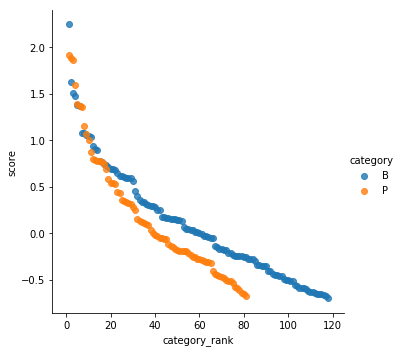

In [97]:
sb.lmplot(x="category_rank", y="score", hue='category', fit_reg=False, data=dfd[dfd['rank'] < 200.0])